# Observational Fairness on COMPAS Dataset
### Julia L. Wang

Reproducing: 

*   Dressel, Julia, and Hany Farid (2018). “The accuracy, fairness, and limits of predicting recidivism."

*   Wadsworth, Christina, Francesca Vera, and Chris Piech (2018). “Achieving fairness through adversarial learning: an application to recidivism prediction.”

Using the COMPAS dataset. 

In [1]:
# Initialization
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain

# COMPAS dataset
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

## Some Definitions

**Calibration:** positive predictive value (PPV) parity and negative predictive value (NPV) parity since the risk scores are 0/1 for not recidivate/ recidivate


*   PPV parity: P ( actually recidivate | model predicts recidivate) is equal for each demographic
*   NPV parity: P( actually recidivate | model predicts won't recidivate) is equal for each demographic



**False-positive parity:** P( model outputs recidivate | didn't actually recidivate) is equal regardless of demographic. 

##  Part 1: Logistic Regression Model

Reproducing Dressel et al. (2019) to predict 2-year recidivism. Dressel et al. split the data into 80% training and 20% testing, where they trained different models with 2  and 7 features respectively. This section will replicate their training using 2 features, and test for false-positive parity and calibration between Caucasian and African-American demographics. 

In [ ]:
## Splitting the data into training and test sets
train, test = train_test_split(df, test_size=0.2) #20% test size

## Training data we need- 2 features: age, priors_count
train_data = torch.tensor(train[["age", "priors_count"]].to_numpy().astype(np.float32))
train_targets = torch.tensor(train[["two_year_recid"]].to_numpy().astype(np.float32))

## Test data for testing all demographics
test_data = torch.tensor(test[["age", "priors_count"]].to_numpy().astype(np.float32))
test_targets = torch.tensor(test[["two_year_recid"]].to_numpy().astype(np.float32))

## Getting test data by race for comparison
caucasian = df[(df.race == "Caucasian")]
aa = df[(df.race == "African-American")]

# get caucasian and african-american data in the training set
aa_in_training = train.merge(aa, on=["id"])
caucasian_in_training = train.merge(caucasian, on=["id"])

# test sets: caucasian and aa not in the training set
aa_test = aa[~aa.id.isin(aa_in_training.id)]
caucasian_test = caucasian[~caucasian.id.isin(caucasian_in_training.id)]

## final data and targets for each demographic
cc_data = torch.tensor(caucasian_test[["age", "priors_count"]].to_numpy().astype(np.float32))
cc_targets = torch.tensor(caucasian_test[["two_year_recid"]].to_numpy().astype(np.float32))

aa_data = torch.tensor(aa_test[["age", "priors_count"]].to_numpy().astype(np.float32))
aa_targets = torch.tensor(aa_test[["two_year_recid"]].to_numpy().astype(np.float32))

# inputs into training logistic regression
x_train = train_data
y_train = train_targets

In [ ]:
## Creating logistic regression model

class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

model = LogisticRegression(2, 1)

In [ ]:
## Training the model

# set model parameters
criterion = torch.nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam optimizer

# Training the model
for epoch in range(1000):
    y_pred = model(x_train) # get model output by inputting the training data
    loss = criterion(y_pred, y_train) # computing loss
    loss.backward()                   # Backward pass

    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1)%100 == 0: # print the accuracy and loss for every 100 epochs
      model_out = torch.where(y_pred>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/y_pred.shape[0], ". Loss is: ", loss.item())


Model accuracy is  tensor(0.6475) . Loss is:  0.6235053539276123
Model accuracy is  tensor(0.6552) . Loss is:  0.6215925812721252
Model accuracy is  tensor(0.6602) . Loss is:  0.6202848553657532
Model accuracy is  tensor(0.6637) . Loss is:  0.6191103458404541
Model accuracy is  tensor(0.6649) . Loss is:  0.6181541681289673
Model accuracy is  tensor(0.6675) . Loss is:  0.6174333095550537
Model accuracy is  tensor(0.6690) . Loss is:  0.6169244050979614
Model accuracy is  tensor(0.6741) . Loss is:  0.6165862083435059
Model accuracy is  tensor(0.6749) . Loss is:  0.6163738369941711
Model accuracy is  tensor(0.6746) . Loss is:  0.6162476539611816


In [ ]:
## Running the model on the test sets

caucasian_pred = model(cc_data) # caucasian test set
aa_pred = model(aa_data)        # african-american test set
overall_pred = model(test_data) # overall case with all demographics


### Calibration and False-Positive parity

In [12]:
def FalsePosRate(model_out, y_test):
  """
    model_out: models predictions of positive or negative (1/0)
    y_test: the ground truth values
    output: the false positive rate = # false positives / total true negatives
  """
  false_pos_count = 0
  total_neg_count = 0

  for i in range(len(model_out)):
    if y_test[i] == 0: # true  negative case
      total_neg_count+=1
      if model_out[i] != y_test[i]: #false pos when true negative & model predicts positive
        false_pos_count+=1
  # print("\tAmount of false positives:", false_pos_count)
  # print("\tAmount of negatives:", total_neg_count)

  return false_pos_count/total_neg_count

# print(FalsePosRate(model_out, y_test))

In [13]:
def Calibration(model_out, targets):
  """
    model_out: the models prediction of 0/1
    targets: the ground truth values
    outputs: PPV = P(ground truth = reoffend | model predicts reoffend)
            NPV = 1 - P(ground truth = reoffend | model predicts won't reoffend)
  """
  total_pos_count = 0
  total_neg_count = 0
  ppv_count = 0
  npv_count = 0

  for i in range(len(model_out)):
    if model_out[i] == 0: # model negative (reoffend)
      total_neg_count+=1
      if targets[i] ==1:  # true positive
        npv_count += 1
        
    else: # model positive case(reoffend)
      total_pos_count += 1
      if targets[i] == 1: # true positive
        ppv_count += 1
  
  PPV = ppv_count/total_pos_count
  NPV = 1-(npv_count/total_neg_count)

  return PPV, NPV

In [ ]:
## Showing that the model fails to satisfy false-positive parity

# Assigning model predictions to 0 or 1
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.5, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.5, 1, 0)

# Calculating false positive rate for each demographic
caucasian_fpr = FalsePosRate(caucasian_pred_thresholded, cc_targets)
print("Caucasian false positive rate:", caucasian_fpr)

aa_fpr = FalsePosRate(aa_pred_thresholded, aa_targets)
print("African-American false positive rate:", aa_fpr)

## conclusion:
print("Difference between them is:", aa_fpr - caucasian_fpr)

#since the false positive rates were not the same between the 2, 
#there is no false positive parity

Caucasian false positive rate: 0.13486842105263158
African-American false positive rate: 0.2657894736842105
Difference between them is: 0.13092105263157894


In [ ]:
## Showing that the model satisfies calibration

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)


Caucasian PPV:  0.646551724137931  African-American PPV:  0.708092485549133 Difference =  0.061540761411201905
Caucasian NPV:  0.6813471502590673  African-American NPV:  0.672289156626506 Difference =  -0.009057993632561323


### Comparing the differences in the demographics for false-positive parity and calibration

For the purposes of this lab, I will define a difference to be significant if it 5% or greater. Thus, it can be seen above that the model does not satisfy false-positive parity since the difference between the false positive rates (FPRs) is 11.95%. On the other hand, the differences between the PPVs and NPVs are 4.12% and 3.44% respectively, which are both under 5% and therefore can be concluded to display parity. Since having both PPV parity and NPV parity means that we have calibration, the model satisfies calibration.

### Base rates

In [ ]:
caucasian = df[(df.race == "Caucasian")]
cc_recid = caucasian["two_year_recid"].to_numpy().astype(np.float32)

aa = df[(df.race == "African-American")]
aa_recid = aa["two_year_recid"].to_numpy().astype(np.float32)

print("African-american recidivism base rate:", np.sum(aa_recid)/aa.shape[0])
print("Caucasian recidivism base rate:", np.sum(cc_recid)/caucasian.shape[0])
print("Difference between base rates: ", np.sum(aa_recid)/aa.shape[0]-np.sum(cc_recid)/caucasian.shape[0])

African-american recidivism base rate: 0.5143398268398268
Caucasian recidivism base rate: 0.39364303178484106
Difference between base rates:  0.12069679505498576


The base rate for recidivism from the African-American demographic is higher than the Caucasian by 12.07%. False-positive parity occurs when people who did not reoffend are predicted to reoffend at the same rate. In this case, my model did not satisfy FFP with a 11.95% difference between false-positive rates, showing more false-positives for the African-American demographic. This is reflective of the base recidivism rate being higher since it causes the model to predict more recidivism for African-Americans.

### Adjusting thresholds

Text(0.5, 1.0, 'Effect of threshold on FPR')

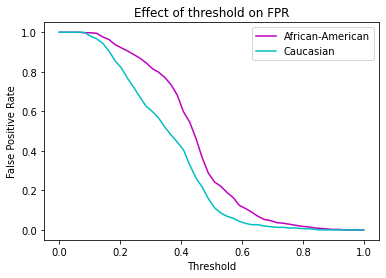

In [ ]:
## Show adjusting thresholds satisfies false-positive parity 
thresholds = np.linspace(0, 1) # change threshold from 0 to 1 on the x-axis

# generate FPR rates for cc and aa
cc_fpr = []
aa_fpr = []

for i in thresholds:
  # taking each model output with different thresholds
  cc_thresholded = torch.where(caucasian_pred>i, 1, 0)
  aa_thresholded = torch.where(aa_pred>i, 1, 0)
  cc_fpr.append(FalsePosRate(cc_thresholded, cc_targets))
  aa_fpr.append(FalsePosRate(aa_thresholded, aa_targets))

# conversion to np array for plotting
cc_fpr = np.array(cc_fpr)
aa_fpr = np.array(aa_fpr)

# plotting
plt.plot(thresholds, aa_fpr, label = "African-American", color = "m")
plt.plot(thresholds, cc_fpr, label = "Caucasian", color= "c")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("False Positive Rate")
plt.title("Effect of threshold on FPR")


Plotting false positive rates with respect to different threshold values leads to the figure above. As such, it can be seen that a threshold of around 0.1 or 0.9 leads to false-positive parity where the rates match between demographics. Selecting these thresholds, let's try to check the calibration.

In [ ]:
## Show that thresholds satisfying false-positive parity doesn't satisfy calibration
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.45, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.7, 1, 0)

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("For 0.1 Threshold:")
print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)

For 0.1 Threshold:
Caucasian PPV:  0.5913978494623656  African-American PPV:  0.8415841584158416 Difference =  0.25018630895347593
Caucasian NPV:  0.7215189873417722  African-American NPV:  0.5515151515151515 Difference =  -0.1700038358266207


For the thresholds for which my model satisfied false-positive parity, the differences in PPV and NPV were significant (>5%), therefore, calibration is not satisfied after the threshold adjustment. 

Further statistical testing is required to conclude the significance of the differences between demographics for false-positive rates, PPV, and NPV. 

## Part 2: Adversial Learning Procedure

Reproducing Wadsworth et al. (2018) to produce more accurate classifier satisfying false-postiive partiy by introducing more features and using an adversial learning procedure.

### Getting data

Wadsworth et al. (2018) had a training set size of 8230 and test size of 2213, which I will approximate as a 20% test size. 

In [2]:
# age, prior_count, sex, juv_misd_count, juv_other_count, juv_fel_count, c_charge_degree
# encoding some features into binary
encoded_sex = pd.Series(np.where(df.sex.values == 'Male', 1, 0), name="enc_sex")
encoded_charge_degree = pd.Series(np.where(df.c_charge_degree.values == 'F', 1, 0), name = "enc_charge_degree")
encoded_race = pd.Series(np.where(df.race.values == "Caucasian", 1, 0), name="enc_race")
newdf = pd.concat([df, encoded_sex, encoded_charge_degree, encoded_race], axis=1)

## Getting test data by race for comparison
caucasian = newdf[(newdf.race == "Caucasian")]
aa = newdf[(newdf.race == "African-American")]
newdf = pd.concat([caucasian, aa]) # dataframe now only consists of caucasian and aa

## Splitting the data into training and test sets
train, test = train_test_split(newdf, test_size=0.2) #20% test size

## Training data we need with 7 features
train_data = torch.tensor(train[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
train_targets = torch.tensor(train[["two_year_recid"]].to_numpy().astype(np.float32))
train_targets2 = torch.tensor(train[["enc_race"]].to_numpy().astype(np.float32))

## Test data for testing all demographics
test_data = torch.tensor(test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
test_targets = torch.tensor(test[["two_year_recid"]].to_numpy().astype(np.float32))
test_targets2 = torch.tensor(test[["enc_race"]].to_numpy().astype(np.float32))

# get caucasian and african-american data in the training set
aa_in_training = train.merge(aa, on=["id"])
caucasian_in_training = train.merge(caucasian, on=["id"])

# test sets: caucasian and aa not in the training set
aa_test = aa[~aa.id.isin(aa_in_training.id)]
caucasian_test = caucasian[~caucasian.id.isin(caucasian_in_training.id)]

## final data and targets for each demographic
cc_data = torch.tensor(caucasian_test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
cc_targets = torch.tensor(caucasian_test[["two_year_recid"]].to_numpy().astype(np.float32))
cc_targets2 = torch.tensor(caucasian_test[["enc_race"]].to_numpy().astype(np.float32))

aa_data = torch.tensor(aa_test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
aa_targets = torch.tensor(aa_test[["two_year_recid"]].to_numpy().astype(np.float32))
aa_targets2 = torch.tensor(aa_test[["enc_race"]].to_numpy().astype(np.float32))

# inputs into training logistic regression
x_train = train_data
y_train = train_targets   # recidivism
y_train2 = train_targets2 # race
newdf

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,enc_sex,enc_charge_degree,enc_race
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,1,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0,0,0,1
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,0,3,0,0,1,428.0,2015-01-06 03:55:34,2015-01-07 03:38:44,13000017CF10A,2012-12-31,NaN,308.0,F,Insurance Fraud,1,15002891MM10A,(M1),0.0,2015-01-06,Battery,2015-01-06,2015-01-07,NaN,1,15000258CF10A,(F2),2015-01-06,Aggrav Battery w/Deadly Weapon,Risk of Recidivism,3,Low,2013-11-04,Risk of Violence,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1,1,1,1
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0,1,1,1
12,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,0,1,0,0,0,0.0,2013-01-01 03:28:03,2013-01-02 01:12:19,13000053MM10A,2013-01-01,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-01-01,Risk of Violence,1,Low,2013-01-01,2013-01-01,2013-01-02,0,1,1186,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,0,2,0,0,0,-1.0,2014-05-09 10:01:33,2014-05-10 08:28:12,14006477CF10A,2014-05-09,NaN,1.0,M,Possess Cannabis/20 Grams Or Less,1,15013710CF10A,(F3),1.0,2015-10-21,Possession of Cannabis,2015-10-22,2015-10-22,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,2014-05-10,Risk of Violence,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1,1,0,0
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,0,9,0,0,0,-1.0,2013-10-19 11:17:15,2013-10-20 08:13:06,13014650CF10A,2013-10-19,NaN,1.0,F,Possession of Cocaine,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,9,High,2013-10-20,Risk of Violence,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0,1,1,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-

**Feature processing:** Features which were strings in the dataset were encoded into integer values- sex and crime degree were converted to binary 0 and 1s for the purposes of training the model. 

Wadsworth et al. (2018) used 10 features: charge degree, age, prior crimes, felonies, misdemeanors, days in jail, juvenile other, charges, juvenile misdemeanors, and jail history. To replicate this, I will be using features: age, sex, number of prior crimes, number of juvenile misdemeanors, number of juvinile felonies, and crime charge degree. 

### Creating models

 2 models: Wadsworth et al. implemented a predictor N and adversary A. I will be replicating the exact hyperparameters described in section 4 of Wadsworth et al. (2018). 

In [7]:
## Predictor N Model
# 2 256-unit ReLU hidden layers
class Predictor(torch.nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        # fully connected layers
        self.fc1 = torch.nn.Linear(7, 256)   # 7 features from the dataset
        self.fc2 = torch.nn.Linear(256, 256) # 2x 256-unit ReLU 
        self.fc3 = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x)) # 2x 256-unit ReLU
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x 

## Adversary A Model
# 100 unit ReLU hidden layer
class Adversary(torch.nn.Module):
    def __init__(self):
        super(Adversary, self).__init__()

        self.fc1 = torch.nn.Linear(1, 100) # logit and true recidivism value
        self.fc2 = torch.nn.Linear(100, 1) # 100-unit ReLU

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # sigmoid output
        return x

model1 = Predictor()
model2 = Adversary()

In [9]:
## Hyperparameters
# taken from section 4 of Wadsworth
learning_rate = np.exp(-4)
alpha = 1
criterion = torch.nn.BCELoss(size_average=True) # binary cross entropy loss
optimizer_pred = torch.optim.Adam(model1.parameters(), lr= learning_rate) #Adam optimizer
optimizer_adv = torch.optim.Adam(model2.parameters(), lr = learning_rate)

### Adverserial learning procedure
# Following Figure 1 in Wadsworth

for epoch in range(250):

    ## zero out all gradients
    optimizer_pred.zero_grad() #2 optimizers for the 2 models
    optimizer_adv.zero_grad()

    ## forward pass
    pred_out = model1(x_train)   # input training data to model N
    y_pred = model2(pred_out)    # predictor output -> Adversary

    # computing adversary model loss, setting up for predictor
    adv_loss = criterion(pred_out, y_train) # computing adversary loss wrt recidivism
    pred_loss_p1 = criterion(y_pred, y_train2) # loss wrt race, to use in predictor loss

    ## backward pass and update adversary model
    adv_loss.backward(retain_graph=True) # retain graph: keeps all memory
    optimizer_adv.step() # update adversary model parameters
    optimizer_adv.zero_grad() # reset gradients to 0

    ## forward pass
    y_pred = model2(pred_out) # running adversary model again

    ## computing predictor model loss
    pred_loss_p1 = criterion(y_pred, y_train2) # loss wrt race, to use in predictor loss
    pred_loss = adv_loss - alpha*pred_loss_p1

    ## backward pass and updating predictor model parameters 
    pred_loss.backward()
    optimizer_pred.step()

    if (epoch+1)%10 == 0: # print the accuracy and loss for every 10 epochs
      model_out = torch.where(pred_out>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/pred_out.shape[0], ". Loss is: ", pred_loss.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Model accuracy is  tensor(0.6488) . Loss is:  -0.07736295461654663
Model accuracy is  tensor(0.6758) . Loss is:  -0.09219801425933838
Model accuracy is  tensor(0.6742) . Loss is:  -0.09711688756942749
Model accuracy is  tensor(0.6752) . Loss is:  -0.10008907318115234
Model accuracy is  tensor(0.6768) . Loss is:  -0.10243254899978638
Model accuracy is  tensor(0.6817) . Loss is:  -0.1043163537979126
Model accuracy is  tensor(0.6817) . Loss is:  -0.10596656799316406
Model accuracy is  tensor(0.6811) . Loss is:  -0.10747706890106201
Model accuracy is  tensor(0.6815) . Loss is:  -0.10863715410232544
Model accuracy is  tensor(0.6815) . Loss is:  -0.10966545343399048
Model accuracy is  tensor(0.6827) . Loss is:  -0.11076027154922485
Model accuracy is  tensor(0.6856) . Loss is:  -0.11143183708190918
Model accuracy is  tensor(0.6864) . Loss is:  -0.11264210939407349
Model accuracy is  tensor(0.6854) . Loss is:  -0.11345183849334717
Model accuracy is  tensor(0.6872) . Loss is:  -0.11407351493835

In [10]:
caucasian_pred = model2(model1(cc_data)) # caucasian test set
aa_pred = model2(model1(aa_data))       # african-american test set
overall_pred = model2(model1((test_data))) # overall case with all demographics

In [14]:
## Showing that the model fails to satisfy false-positive parity

# Assigning model predictions to 0 or 1
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.5, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.5, 1, 0)

# Calculating false positive rate for each demographic
caucasian_fpr = FalsePosRate(caucasian_pred_thresholded, cc_targets)
print("Caucasian false positive rate:", caucasian_fpr)

aa_fpr = FalsePosRate(aa_pred_thresholded, aa_targets)
print("African-American false positive rate:", aa_fpr)

## conclusion:
print("Difference between them is:", aa_fpr - caucasian_fpr)

#since the false positive rates were not the same between the 2, 
#there is no false positive parity

Caucasian false positive rate: 1.0
African-American false positive rate: 1.0
Difference between them is: 0.0


### Results
Features used: sex, age, number of priors, 

Comparison to Wadsworth:

False-positive disparity